In [1]:
!nvidia-smi

Tue Jul 16 14:46:21 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8    17W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
iteration = 50
batchsize = 80
snapshot_interval = 5
display_interval = snapshot_interval
update_interval = snapshot_interval
sa_gamma = 1e-6
phase = 0
IMG_SHAPE = (32, 32)
this_resolution_is_start = False
this_resolution_is_fin = False
GPU = 0
'''
0- : all decoder training.
1- : trans encoding.(hold)
'''

'\n0- : all decoder training.\n1- : trans encoding.(hold)\n'

In [3]:
mount = '/content/gdrive'

from google.colab import drive
drive.mount(mount)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
OUT = mount+'/My Drive/result/'
dataset = mount+'/My Drive/picture/train_pic/**/*.jpg'

In [0]:
import numpy
import math
import glob
from PIL import Image, ImageOps, ImageChops, ImageFilter
import matplotlib.pyplot as plt
import cupy

import chainer
from chainer import training, backend, Variable
from chainer.training import extensions
import chainer.functions as F
import chainer.links as L
import chainer.backends.cuda

from IPython.display import clear_output

In [0]:
def gaussian(size):
    return F.gaussian(cupy.zeros(size, dtype=cupy.float32),
                     cupy.ones(size, dtype=cupy.float32))

In [0]:
def make_optimizer_Adam(model, alpha=1e-4, beta1=0.9, clip=True):
    optimizer = chainer.optimizers.Adam(alpha=alpha, beta1=beta1)
    optimizer.setup(model)
    if clip:
        optimizer.add_hook(chainer.optimizer_hooks.GradientClipping(1.))
    return optimizer

In [0]:
def out_generated_image(gen, c_iter, v_iter):
    @chainer.training.make_extension()
    def make_image(trainer):
        clear_output()
        xp = gen.xp
        c_base = xp.asarray(c_iter.next())
        z_c = Variable(c_base[:,1])/255. *2. -1.
        if phase < 1:
            v_base = c_base[:,0]
        else:
            v_base = xp.asarray(v_iter.next())[:,0]
        z_v = Variable(v_base)/255. *2. -1.
        
        with chainer.using_config('train', False):
            x, zs, seg, tx = gen(z_c, z_v)
            
        x = F.transpose(F.reshape(x, (-1, 3)+IMG_SHAPE), (0, 2, 3, 1))
        x = chainer.backends.cuda.to_cpu(x.array)
        zs = chainer.backends.cuda.to_cpu(zs.array)
        seg = F.transpose(F.reshape(seg, (-1, 3)+IMG_SHAPE), (0, 2, 3, 1))
        seg = chainer.backends.cuda.to_cpu(seg.array)
        tx = F.transpose(F.reshape(tx, (-1, 3)+IMG_SHAPE), (0, 2, 3, 1))
        tx = chainer.backends.cuda.to_cpu(tx.array)
        
        plt.figure(figsize=(16, 24))
        
        for i, img in enumerate(xp.asnumpy(c_base[:,1])):
            plt.subplot(6, 4, i+1).axis('off')
            plt.subplot(6, 4, i+1).imshow(Image.fromarray(numpy.uint8(img).transpose((1, 2, 0))))
            
        for i, img in enumerate(seg):
            plt.subplot(6, 4, i+5).axis('off')
            plt.subplot(6, 4, i+5).imshow(Image.fromarray(numpy.uint8((img+1.)/2. *255.)))
            
        for i, img in enumerate(x):
            plt.subplot(6, 4, i+9).axis('off')
            plt.subplot(6, 4, i+9).imshow(Image.fromarray(numpy.uint8((img+1.)/2. *255.)))

        for i, img in enumerate(tx):
            plt.subplot(6, 4, i+13).axis('off')
            plt.subplot(6, 4, i+13).imshow(Image.fromarray(numpy.uint8((img+1.)/2. *255.)))
            
        ax = plt.subplot2grid((6, 4), (4, 0), colspan=4)
        for i, zs in enumerate(zs):
            ax.plot(zs,
                    marker='.',
                    linestyle='None',
                    label='z({})'.format(i),
                    color='rgbk'[i])
            ax.legend()
            
        for i, img in enumerate(xp.asnumpy(v_base)):
            plt.subplot(6, 4, i+21).axis('off')
            plt.subplot(6, 4, i+21).imshow(Image.fromarray(numpy.uint8(img).transpose((1, 2, 0))))
        
        plt.show()
    return make_image

In [0]:
class DiscriminatorGen(chainer.Chain):

    def __init__(self, wscale=3e-1, sa_gamma=1e-6):
        super(DiscriminatorGen, self).__init__()
        self.sa_gamma = sa_gamma
        
        with self.init_scope():
            w = chainer.initializers.HeNormal(wscale)
            
            self.c0_0 = L.Convolution2D(3, 64, 1, 1, 0, initialW=w)
            self.bn0_0 = L.BatchNormalization(64)
            self.c0_1 = L.Convolution2D(None, 64, 3, 1, 1, initialW=w)
            self.bn0_1 = L.BatchNormalization(64)
            self.c0_2 = L.Convolution2D(None, 64, 3, 1, 1, initialW=w)
            self.bn0_2 = L.BatchNormalization(64)
            
            self.c1_0 = L.Convolution2D(None, 128, 1, 1, 0, initialW=w)
            self.bn1_0 = L.BatchNormalization(128)
            self.c1_1 = L.Convolution2D(None, 128, 1, 1, 0, initialW=w)
            self.bn1_1 = L.BatchNormalization(128)
            self.c1_2 = L.Convolution2D(None, 128, 1, 1, 0, initialW=w)
            self.bn1_2 = L.BatchNormalization(128)
            self.c1_3 = L.Convolution2D(None, 128, 1, 1, 0, initialW=w)
            self.bn1_3 = L.BatchNormalization(128)
            ''' ---128px image training---
            self.c1_4 = L.Convolution2D(None, 128, 3, 1, 1, initialW=w)
            self.bn1_4 = L.BatchNormalization(128)
            self.c1_5 = L.Convolution2D(None, 128, 3, 1, 1, initialW=w)
            self.bn1_5 = L.BatchNormalization(128)
            '''
            ''' ---64px image training---
            self.c2_0 = L.Convolution2D(None, 256, 3, 1, 1, initialW=w)
            self.bn2_0 = L.BatchNormalization(256)
            self.c2_1 = L.Convolution2D(None, 256, 3, 1, 1, initialW=w)
            self.bn2_1 = L.BatchNormalization(256)
            '''
            self.c3_0 = L.Convolution2D(None, 512, 3, 1, 1, initialW=w)
            self.bn3_0 = L.BatchNormalization(512)
            self.c3_1 = L.Convolution2D(None, 512, 3, 1, 1, initialW=w)
            self.bn3_1 = L.BatchNormalization(512)
            
            self.c4_0 = L.Convolution2D(None, 512, 3, 1, 1, initialW=w)
            self.bn4_0 = L.BatchNormalization(512)
            self.c4_1 = L.Convolution2D(None, 512, 3, 1, 1, initialW=w)
            self.bn4_1= L.BatchNormalization(512)
            
            self.c5_0 = L.Convolution2D(None, 512, 3, 1, 1, initialW=w)
            self.bn5_0 = L.BatchNormalization(512)
            self.c5_1 = L.Convolution2D(None, 512, 3, 1, 1, initialW=w)
            self.bn5_1 = L.BatchNormalization(512)
            self.l_m = L.Linear(None, 512, initialW=w)
            self.t = L.Linear(None, 64*16, initialW=None)
            
            self.l_o = L.Linear(None, 1, initialW=w)
    
    def __call__(self, z):
        batchsize = z.shape[0]
        x = F.leaky_relu(self.bn0_0(self.c0_0(self.gaussian(z))))
        x = F.leaky_relu(self.bn0_1(self.c0_1(self.gaussian(x))))
        _x = F.leaky_relu(self.bn0_2(self.c0_2(self.gaussian(x))))
        x = F.add(x, _x)
        # 128
        x = F.average_pooling_2d(x, 2)
        x = F.leaky_relu(self.bn1_0(self.c1_0(x)))
        f = F.tanh(self.bn1_1(self.c1_1(x)))
        g = F.tanh(self.bn1_2(self.c1_2(x)))
        h = F.tanh(self.bn1_3(self.c1_3(x)))
        x = F.leaky_relu(self.self_attention(x, f, g, h))
        ''' ---128px image training---
        x = F.leaky_relu(self.bn1_4(self.c1_4(self.gaussian(x))))
        _x = F.leaky_relu(self.bn1_5(self.c1_5(self.gaussian(x))))
        x = F.add(x, _x)
        # 64
        x = F.average_pooling_2d(x, 2)
        '''
        ''' ---64px image training---
        x = F.leaky_relu(self.bn2_0(self.c2_0(self.gaussian(x))))
        _x = F.leaky_relu(self.bn2_1(self.c2_1(self.gaussian(x))))
        x = F.add(x, _x)
        # 32
        x = F.average_pooling_2d(x, 2)
        '''
        x = F.leaky_relu(self.bn3_0(self.c3_0(self.gaussian(x))))
        _x = F.leaky_relu(self.bn3_1(self.c3_1(self.gaussian(x))))
        x = F.add(x, _x)
        # 16
        x = F.average_pooling_2d(x, 2)
        x = F.leaky_relu(self.bn4_0(self.c4_0(self.gaussian(x))))
        _x = F.leaky_relu(self.bn4_1(self.c4_1(self.gaussian(x))))
        x = F.add(x, _x)
        # 8
        x = F.average_pooling_2d(x, 2)
        x = F.leaky_relu(self.bn5_0(self.c5_0(self.gaussian(x))))
        _x = F.leaky_relu(self.bn5_1(self.c5_1(self.gaussian(x))))
        x = F.add(x, _x)
        x = self.gap(x)
        # 4
        
        h_m = F.leaky_relu(self.l_m(x))
        m = F.reshape(self.t(h_m), (batchsize, 64, 16))
        o_b = self.minibatch_discrimination(m)
        
        x = F.concat((h_m, o_b), axis=1)
        
        return self.l_o(x), h_m

    def minibatch_discrimination(self, m):
        batchsize = m.shape[0]
        m = F.expand_dims(m, 3)
        m_T = F.transpose(m, (3, 1, 2, 0))
        m, m_T = F.broadcast(m, m_T)
        norm = F.sum(F.absolute_error(m, m_T), axis=2)
        eraser = F.broadcast_to(cupy.eye(batchsize, dtype=cupy.float32).reshape((batchsize, 1, batchsize)), norm.shape)
        c_b = F.exp(-(norm + 1e6 * eraser))
        o_b = F.sum(c_b, axis=2)
        return o_b
        
    def gaussian(self, x):
        return F.gaussian(x, cupy.ones(x.shape, dtype=cupy.float32)*2e-2)

    def self_attention(self, x, f, g, h):
        _f = F.reshape(f, f.shape[:2]+(-1,))
        _g = F.reshape(g, g.shape[:2]+(-1,))
        _h = F.reshape(h, h.shape[:2]+(-1,))
        
        attention_map = F.batch_matmul(_f, _g, transa=True)
        feature_map = F.batch_matmul(_h, attention_map, transb=True)
        feature_map = F.reshape(feature_map, x.shape)
        return F.add(x, feature_map*self.sa_gamma)
    
    def gap(self, x):
        return F.average_pooling_2d(x, x.shape[-2:])

In [0]:
class Generator(chainer.Chain):

    def __init__(self, wscale=3e-1, sa_gamma=1e-6):
        super(Generator, self).__init__()
        self.sa_gamma = sa_gamma

        with self.init_scope():
            w = chainer.initializers.HeNormal(wscale)
            
            self.txc0_0 = L.Convolution2D(3, 64, 1, 1, 0, initialW=w)
            self.txcbn0_0 = L.BatchNormalization(64)
            self.txc0_1 = L.Convolution2D(None, 64, 3, 1, 1, initialW=w)
            self.txcbn0_1 = L.BatchNormalization(64)
            self.txc0_2 = L.Convolution2D(None, 64, 3, 1, 1, initialW=w)
            self.txcbn0_2 = L.BatchNormalization(64)
            
            self.txc1_0 = L.Convolution2D(None, 128, 1, 1, 0, initialW=w)
            self.txcbn1_0 = L.BatchNormalization(128)
            self.txc1_1 = L.Convolution2D(None, 128, 1, 1, 0, initialW=w)
            self.txcbn1_1 = L.BatchNormalization(128)
            self.txc1_2 = L.Convolution2D(None, 128, 1, 1, 0, initialW=w)
            self.txcbn1_2 = L.BatchNormalization(128)
            self.txc1_3 = L.Convolution2D(None, 128, 1, 1, 0, initialW=w)
            self.txcbn1_3 = L.BatchNormalization(128)
            self.txc1_4 = L.Convolution2D(None, 128, 3, 1, 1, initialW=w)
            self.txcbn1_4 = L.BatchNormalization(128)
            self.txc1_5 = L.Convolution2D(None, 128, 3, 1, 1, initialW=w)
            self.txcbn1_5 = L.BatchNormalization(128)
            
            self.txc2_0 = L.Convolution2D(None, 256, 3, 1, 1, initialW=w)
            self.txcbn2_0 = L.BatchNormalization(256)
            self.txc2_1 = L.Convolution2D(None, 256, 3, 1, 1, initialW=w)
            self.txcbn2_1 = L.BatchNormalization(256)
            
            self.txc3_0 = L.Convolution2D(None, 512, 3, 1, 1, initialW=w)
            self.txcbn3_0 = L.BatchNormalization(512)
            self.txc3_1 = L.Convolution2D(None, 512, 3, 1, 1, initialW=w)
            self.txcbn3_1 = L.BatchNormalization(512)
            
            self.txc4_0 = L.Convolution2D(None, 512, 3, 1, 1, initialW=w)
            self.txcbn4_0 = L.BatchNormalization(512)
            self.txc4_1 = L.Convolution2D(None, 512, 3, 1, 1, initialW=w)
            self.txcbn4_1 = L.BatchNormalization(512)
            
            self.txc5_0 = L.Convolution2D(None, 512, 3, 1, 1, initialW=w)
            self.txcbn5_0 = L.BatchNormalization(512)
            self.txc5_1 = L.Convolution2D(None, 512, 3, 1, 1, initialW=w)
            self.txcbn5_1 = L.BatchNormalization(512)
            
            self.txl1 = L.Linear(None, 512, initialW=w)
            self.txlbn1 = L.BatchNormalization(512)
            self.txl2 = L.Linear(None, 512, initialW=w)
            self.txlbn2 = L.BatchNormalization(512)
            self.txl3 = L.Linear(None, 512, initialW=w)
            
            self.txbtm = L.Linear(None, 512*8*8, initialW=w)
            
            self.enc0_0 = L.Convolution2D(3, 64, 1, 1, 0, initialW=w)
            self.enbnc0_0 = L.BatchNormalization(64)
            self.enc0_1 = L.Convolution2D(None, 64, 3, 1, 1, initialW=w)
            self.enbnc0_1 = L.BatchNormalization(64)
            
            self.enc1_0 = L.Convolution2D(None, 128, 1, 1, 0, initialW=w)
            self.enbnc1_0 = L.BatchNormalization(128)
            self.enc1_1 = L.Convolution2D(None, 128, 3, 1, 1, initialW=w)
            self.enbnc1_1 = L.BatchNormalization(128)
            
            self.enc2_1 = L.Convolution2D(None, 128, 3, 1, 1, initialW=w)
            self.enbnc2_1 = L.BatchNormalization(128)
            
            self.enc3_1 = L.Convolution2D(None, 128, 3, 1, 1, initialW=w)
            self.enbnc3_1 = L.BatchNormalization(128)
            
            self.enc_gamma = L.Convolution2D(None, 128, 1, 1, 0, initialW=w)
            self.enbnc_gamma = L.BatchNormalization(128)
            self.enc_beta = L.Convolution2D(None, 128, 1, 1, 0, initialW=w)
            self.enbnc_beta = L.BatchNormalization(128)
            
            self.de5_0 = L.Convolution2D(None, 512, 3, 1, 1, initialW=w)
            self.debn5_0 = L.BatchNormalization(512)
            self.de5_1 = L.Convolution2D(None, 512, 3, 1, 1, initialW=w)
            self.debn5_1 = L.BatchNormalization(512)
            
            self.de4_0 = L.Convolution2D(None, 512, 1, 1, 0, initialW=w)
            self.debn4_0 = L.BatchNormalization(512)
            self.de4_1 = L.Convolution2D(None, 512, 3, 1, 1, initialW=w)
            self.debn4_1 = L.BatchNormalization(512)
            self.de4_2 = L.Convolution2D(None, 512, 3, 1, 1, initialW=w)
            self.debn4_2 = L.BatchNormalization(512)
            
            ''' ---64px image training---
            self.de3_0 = L.Convolution2D(None, 256, 1, 1, 0, initialW=w)
            self.debn3_0 = L.BatchNormalization(256)
            self.de3_1 = L.Convolution2D(None, 256, 3, 1, 1, initialW=w)
            self.debn3_1 = L.BatchNormalization(256)
            self.de3_2 = L.Convolution2D(None, 256, 3, 1, 1, initialW=w)
            self.debn3_2 = L.BatchNormalization(256)
            '''
            ''' ---128px image training---
            self.de2_0 = L.Convolution2D(None, 128, 1, 1, 0, initialW=w)
            self.debn2_0 = L.BatchNormalization(128)
            self.de2_1 = L.Convolution2D(None, 128, 3, 1, 1, initialW=w)
            self.debn2_1 = L.BatchNormalization(128)
            self.de2_2 = L.Convolution2D(None, 128, 3, 1, 1, initialW=w)
            self.debn2_2 = L.BatchNormalization(128)
            '''
            
            self.de2_3 = L.Convolution2D(None, 128, 1, 1, 0, initialW=w)
            self.debn2_3 = L.BatchNormalization(128)
            
            self.de2_4 = L.Convolution2D(None, 128, 1, 1, 0, initialW=w)
            self.debn2_4 = L.BatchNormalization(128)
            
            self.de1_0 = L.Convolution2D(None, 64, 1, 1, 0, initialW=w)
            self.debn1_0 = L.BatchNormalization(64)
            self.de1_1 = L.Convolution2D(None, 64, 3, 1, 1, initialW=w)
            self.debn1_1 = L.BatchNormalization(64)
            self.de1_2 = L.Convolution2D(None, 64, 3, 1, 1, initialW=w)
            self.debn1_2 = L.BatchNormalization(64)
            
            self.c_out = L.Convolution2D(None, 3, 1, 1, 0, initialW=w)
    
    def __call__(self, x, style):        
        batch = x.shape[0]
        z = self.tx_encode(style)
        g, b = self.seg_generate(x)
        h = self.decode(z, batch)
        
        seg_out = self.out_generate(F.add(g, b), batch)
        tx_out = self.out_generate(h, batch)
        h = self.out_generate(h, batch, g=g, b=b)
        return h, z, seg_out, tx_out

    def self_attention(self, x, f, g, h):
        _f = F.reshape(f, f.shape[:2]+(-1,))
        _g = F.reshape(g, g.shape[:2]+(-1,))
        _h = F.reshape(h, h.shape[:2]+(-1,))
        
        attention_map = F.batch_matmul(_f, _g, transa=True)
        feature_map = F.batch_matmul(_h, attention_map, transb=True)
        feature_map = F.reshape(feature_map, x.shape)
        return F.add(x, feature_map*self.sa_gamma)
    
    def gap(self, x):
        return F.average_pooling_2d(x, x.shape[-2:])
    
    def spade(self, feature, gamma, beta):
        x = feature*(1+gamma)
        x = F.add(x, beta)
        return x
    
    def gaussian(self, x):
        return F.gaussian(x, cupy.ones(x.shape, dtype=cupy.float32)*1e-2)
    
    def tx_encode(self, s):
        z = F.leaky_relu(self.txcbn0_0(self.txc0_0(s)))
        z = F.leaky_relu(self.txcbn0_1(self.txc0_1(z)))
        _z = F.leaky_relu(self.txcbn0_2(self.txc0_2(z)))
        z = F.add(z, _z)
        # 128
        z = F.average_pooling_2d(z, 2)
        z = F.leaky_relu(self.txcbn1_0(self.txc1_0(z)))
        f = F.tanh(self.txcbn1_1(self.txc1_1(z)))
        g = F.tanh(self.txcbn1_2(self.txc1_2(z)))
        h = F.tanh(self.txcbn1_3(self.txc1_3(z)))
        z = F.leaky_relu(self.self_attention(z, f, g, h))
        z = F.leaky_relu(self.txcbn1_4(self.txc1_4(z)))
        _z = F.leaky_relu(self.txcbn1_5(self.txc1_5(z)))
        z = F.add(z,_z)
        # 64
        z = F.average_pooling_2d(z, 2)
        z = F.leaky_relu(self.txcbn2_0(self.txc2_0(z)))
        _z = F.leaky_relu(self.txcbn2_1(self.txc2_1(z)))
        z = F.add(z, _z)
        # 32
        z = F.average_pooling_2d(z, 2)
        z = F.leaky_relu(self.txcbn3_0(self.txc3_0(z)))
        _z = F.leaky_relu(self.txcbn3_1(self.txc3_1(z)))
        z = F.add(z, _z)
        # 16
        z = F.average_pooling_2d(z, 2)
        z = F.leaky_relu(self.txcbn4_0(self.txc4_0(z)))
        _z = F.leaky_relu(self.txcbn4_1(self.txc4_1(z)))
        z = F.add(z, _z)
        # 8
        z = F.average_pooling_2d(z, 2)
        z = F.leaky_relu(self.txcbn5_0(self.txc5_0(z)))
        _z = F.leaky_relu(self.txcbn5_1(self.txc5_1(z)))
        z = F.add(z, _z)
        # 4
        z = self.gap(z)
        
        z = F.leaky_relu(self.txlbn1(self.txl1(z)))
        z = F.leaky_relu(self.txlbn2(self.txl2(z)))
        z = F.tanh(self.txl3(z))
        return z
    
    def seg_generate(self, x):
        s = F.leaky_relu(self.enbnc0_0(self.enc0_0(x)))
        f = F.leaky_relu(self.enbnc0_1(self.enc0_1(s)))
        # 128
        s = F.space2depth(s, 2)
        f = F.average_pooling_2d(f, 2)
        s = F.tanh(self.enbnc1_0(self.enc1_0(s)))
        f = F.leaky_relu(self.enbnc1_1(self.enc1_1(f)))
        # 64
        f = F.average_pooling_2d(f, 2)
        f = F.leaky_relu(self.enbnc2_1(self.enc2_1(f)))
        # 32
        f = F.average_pooling_2d(f, 2)
        f = F.leaky_relu(self.enbnc3_1(self.enc3_1(f)))
        # 16
        f = F.unpooling_2d(f, 4, cover_all=False)
        f = F.leaky_relu(f*s)
        
        g = F.tanh(self.enbnc_gamma(self.enc_gamma(f)))
        b = F.tanh(self.enbnc_beta(self.enc_beta(f)))
        return g, b
    
    def decode(self, z, batch):
        h = F.leaky_relu(F.reshape(self.txbtm(z), (-1, 512, 8, 8)))
        h = F.leaky_relu(self.debn5_0(self.de5_0(self.gaussian(h))))
        _h = F.leaky_relu(self.debn5_1(self.de5_1(self.gaussian(h))))
        h = F.add(h, _h)
        # 8
        h = F.depth2space(h, 2)
        h = F.leaky_relu(self.debn4_0(self.de4_0(h)))
        h = F.leaky_relu(self.debn4_1(self.de4_1(self.gaussian(h))))
        _h = F.leaky_relu(self.debn4_2(self.de4_2(self.gaussian(h))))
        h = F.add(h, _h)
        # 16
        ''' ---64px image training---
        h = F.depth2space(h, 2)
        h = F.leaky_relu(self.debn3_0(self.de3_0(h)))
        h = F.leaky_relu(self.debn3_1(self.de3_1(self.gaussian(h))))
        _h = F.leaky_relu(self.debn3_2(self.de3_2(self.gaussian(h))))
        h = F.add(h, _h)
        '''
        '''---128px image training---
        # 32
        h = F.depth2space(h, 2)
        h = F.leaky_relu(self.debn2_0(self.de2_0(h)))
        h = F.leaky_relu(self.debn2_1(self.de2_1(self.gaussian(h))))
        _h = F.leaky_relu(self.debn2_2(self.de2_2(self.gaussian(h))))
        h = F.add(h, _h)
        '''
        h = F.leaky_relu(self.debn2_3(self.de2_3(h)))
        return h
    
    def out_generate(self, tx, batch, g=None, b=None):
        if g is not None and b is not None:
            h = F.leaky_relu(self.spade(tx, g, b))
            h = F.leaky_relu(self.debn2_4(self.de2_4(h)))
            h = F.depth2space(h, 2)
        else:
            h = F.depth2space(tx, 2)
        
        h = F.leaky_relu(self.debn1_0(self.de1_0(h)))
        h = F.leaky_relu(self.debn1_1(self.de1_1(self.gaussian(h))))
        _h = F.leaky_relu(self.debn1_2(self.de1_2(self.gaussian(h))))
        h = F.add(h, _h)
        
        h = F.tanh(self.c_out(h))
        return h

In [0]:
class DCGANUpdater(chainer.training.updaters.StandardUpdater):

    def __init__(self, *args, **kwargs):
        self.gen, self.dis_gen = kwargs.pop('models')
        self.cache_dis_gen = None
        self.k = 5
        super(DCGANUpdater, self).__init__(*args, **kwargs)

    def loss_dis(self, dis, loss, opt):
        chainer.report({opt: loss}, dis)
        return loss
    
    def loss_gen(self, gen, losses):
        loss = F.sum(losses) 
        chainer.report({'loss': loss,
                        'fake': losses[0],
                        'rec': losses[2],
                        'tx': losses[3],
                        'seg': losses[5],
                        'z': losses[-1]}, gen)
        return loss

    def update_core(self):
        gen_optimizer = self.get_optimizer('gen')
        dis_gen_optimizer = self.get_optimizer('dis_gen')
        
        gen, dis_gen = self.gen, self.dis_gen
        main_iter = self.get_iterator('main')
        style_iter = self.get_iterator('style')
        
        for k in range(self.k):
            batch_c = main_iter.next()
            batchsize = len(batch_c)
            x_c = Variable(self.converter(batch_c, device=self.device)) /255. *2. -1.
            x_c_real = x_c[:,0]
            x_c_base = x_c[:,1]

            batch_v = style_iter.next()
            x_v_real = Variable(self.converter(batch_v, device=self.device))[:,0] /255. *2. -1.
            
            if phase >= 1:
                x_fake, z, seg_fake, tx_fake = gen(x_c_base, x_v_real)
            else:
                x_fake, z, seg_fake, tx_fake = gen(x_c_base, x_c_real)
            
            y_c_real, fm_c_real = dis_gen(x_c_real)
            y_seg_fake, fm_seg_fake = dis_gen(seg_fake)
            dis_loss_real = F.mean((y_c_real-1)**2)
            dis_gen_optimizer.update(self.loss_dis, dis_gen, dis_loss_real, 'c_real')
            dis_loss_seg = F.mean(y_seg_fake**2)
            dis_gen_optimizer.update(self.loss_dis, dis_gen, dis_loss_seg, 'fake_seg')
            
            if k == self.k-1:
                seg_loss = F.mean((y_seg_fake-1)**2)
                seg_rec_loss = F.mean_squared_error(x_c_base, seg_fake)**2
                seg_fm_loss = F.mean_squared_error(fm_c_real, fm_seg_fake)
                
            del y_seg_fake, fm_seg_fake
            
            y_v_real, fm_v_real = dis_gen(x_v_real)
            y_tx_fake, fm_tx_fake = dis_gen(tx_fake)
            dis_loss_real = F.mean((y_v_real-1)**2)
            dis_gen_optimizer.update(self.loss_dis, dis_gen, dis_loss_real, 'v_real')
            dis_loss_tx = F.mean(y_tx_fake**2)
            dis_gen_optimizer.update(self.loss_dis, dis_gen, dis_loss_tx, 'fake_tx')
            
            if k == self.k-1:
                tx_loss = F.mean((y_tx_fake-1)**2)
                if phase < 1:
                    tx_fm_loss = F.mean_squared_error(fm_c_real, fm_tx_fake)
                else:
                    tx_fm_loss = F.mean_squared_error(fm_v_real, fm_tx_fake)
                
            del y_tx_fake, fm_tx_fake
            
            y_fake, fm_fake = dis_gen(x_fake)
            if phase < 1:
                dis_loss_real = F.mean((y_c_real-1)**2)
            else:
                dis_loss_real = F.mean((y_v_real-1)**2)
            dis_gen_optimizer.update(self.loss_dis, dis_gen, dis_loss_real, 'repeat')
            dis_loss_fake = F.mean(y_fake**2)
            dis_gen_optimizer.update(self.loss_dis, dis_gen, dis_loss_fake, 'fake')
            
            if k == self.k-1:
                fake_loss = F.mean((y_fake-1)**2)
                reconst_loss = F.mean_squared_error(x_c_base, x_fake)**2
                if phase < 1:
                    fm_loss = F.mean_squared_error(fm_c_real, fm_fake)
                else:
                    fm_loss = F.mean_squared_error(fm_v_real, fm_fake)
                    
            del y_fake, fm_fake, y_v_real, fm_v_real, y_c_real, fm_c_real
                
            if self.cache_dis_gen is None:
                self.cache_dis_gen = dis_gen.copy('copy')
                
        dis_gen.copyparams(self.cache_dis_gen)
        self.cache_dis_gen = None
        
        z_loss = F.gaussian_kl_divergence(cupy.zeros(z.shape, dtype=cupy.float32), z)*1e-2

        gen_optimizer.update(self.loss_gen, gen, F.stack((fake_loss,
                                                          fm_loss,
                                                          reconst_loss,
                                                          tx_loss,
                                                          tx_fm_loss,
                                                          seg_loss,
                                                          seg_fm_loss,
                                                          seg_rec_loss,
                                                          z_loss)))

In [0]:
gen = Generator(sa_gamma=sa_gamma)
dis_gen = DiscriminatorGen(sa_gamma=sa_gamma)

In [13]:
chainer.backends.cuda.get_device_from_id(GPU).use()
gen.to_gpu()
dis_gen.to_gpu()

In [0]:
opt_gen = make_optimizer_Adam(gen, clip=False)
opt_dis_gen = make_optimizer_Adam(dis_gen, clip=False)
dis_gen.t.disable_update()

In [0]:
def crop_sq(img):
    img_width, img_height = img.size
    sub = img_width - img_height
    if sub == 0:
        return img
    crop_size = min(img.size)
    crop_position = numpy.random.randint(0, abs(sub))
    if sub > 0:
        return img.crop((crop_position, 0, crop_size+crop_position, crop_size))
    else:
        return img.crop((0, crop_position, crop_size, crop_size+crop_position))

In [0]:
def img_convert(img_array):
    img = Image.fromarray(numpy.uint8(img_array.transpose(1, 2, 0))).convert('RGB')
    image_trans_trigger = numpy.random.randn(2)
    
    real_img = crop_sq(img)
    base_img = crop_sq(img)
        
    if image_trans_trigger[0] > 0:
        real_img = ImageOps.mirror(real_img)
        
    if image_trans_trigger[1] > 0:
        real_img = real_img.resize(IMG_SHAPE)
    else:
        real_img = real_img.resize((IMG_SHAPE[0]+IMG_SHAPE[0]//8, IMG_SHAPE[1]+IMG_SHAPE[1]//8))
        crop_position = numpy.random.randint(0, IMG_SHAPE[0]//8, 2)
        real_img = real_img.crop((crop_position[0],
                                  crop_position[1],
                                  crop_position[0]+IMG_SHAPE[0],
                                  crop_position[1]+IMG_SHAPE[1]))

    real_array = numpy.asarray(real_img, dtype=numpy.float32).transpose(2, 0, 1)
        
    base_img = base_img.resize(IMG_SHAPE)
    
    base_img = base_img.filter(ImageFilter.GaussianBlur(1.0))
    base_img = base_img.filter(ImageFilter.SMOOTH_MORE)
    base_img = base_img.quantize(8, kmeans=True).convert('RGB')
    
    base_array = numpy.asarray(base_img, dtype=numpy.float32).transpose(2, 0, 1)
    
    out_array = numpy.concatenate((real_array[None, :, :, :],
                                   base_array[None, :, :, :]), axis=0)
    return out_array

In [17]:
image_files = glob.glob(dataset, recursive=True)
print('{} contains {} image files'
      .format(dataset, len(image_files)))
img_dataset = chainer.datasets.ImageDataset(paths=image_files)

train = chainer.datasets.TransformDataset(img_dataset, img_convert)
sample = chainer.datasets.TransformDataset(img_dataset, img_convert)

/content/gdrive/My Drive/picture/train_pic/**/*.jpg contains 1062026 image files


In [0]:
train_c_iter = chainer.iterators.SerialIterator(train, batchsize, shuffle=True)
train_v_iter = chainer.iterators.SerialIterator(train, batchsize, shuffle=True)

In [0]:
updater = DCGANUpdater(
    models=(gen, dis_gen),
    iterator={'main': train_v_iter, 'style': train_c_iter},
    optimizer={'gen': opt_gen, 'dis_gen': opt_dis_gen},
    device=GPU)

In [0]:
trainer = training.Trainer(updater, (iteration, 'iteration'), out=OUT)

In [0]:
snapshot_interval = (snapshot_interval, 'iteration')
display_interval = (display_interval, 'iteration')

In [0]:
trainer.extend(extensions.LogReport(trigger=display_interval))
trainer.extend(out_generated_image(gen,
                                   chainer.iterators.SerialIterator(sample, 4, shuffle=True),
                                   chainer.iterators.SerialIterator(sample, 4, shuffle=True)),
               trigger=snapshot_interval)
trainer.extend(extensions.PrintReport([
    'epoch', 'iteration', 'dis_gen/c_real', 'gen/loss', 'gen/fake', 'gen/seg', 'gen/tx', 'gen/z'
    ]), trigger=display_interval)
trainer.extend(extensions.ProgressBar(update_interval=update_interval))

In [0]:
if phase > 0:
    chainer.serializers.load_npz(OUT+'korosu_gen.npz', gen, strict=False)
    chainer.serializers.load_npz(OUT+'korosu_dis_gen.npz', dis_gen, strict=False)
    if not this_resolution_is_start:
        chainer.serializers.load_npz(OUT+'korosu_opt_gen.npz', opt_gen, strict=False)
        chainer.serializers.load_npz(OUT+'korosu_opt_dis_gen.npz', opt_dis_gen, strict=False)

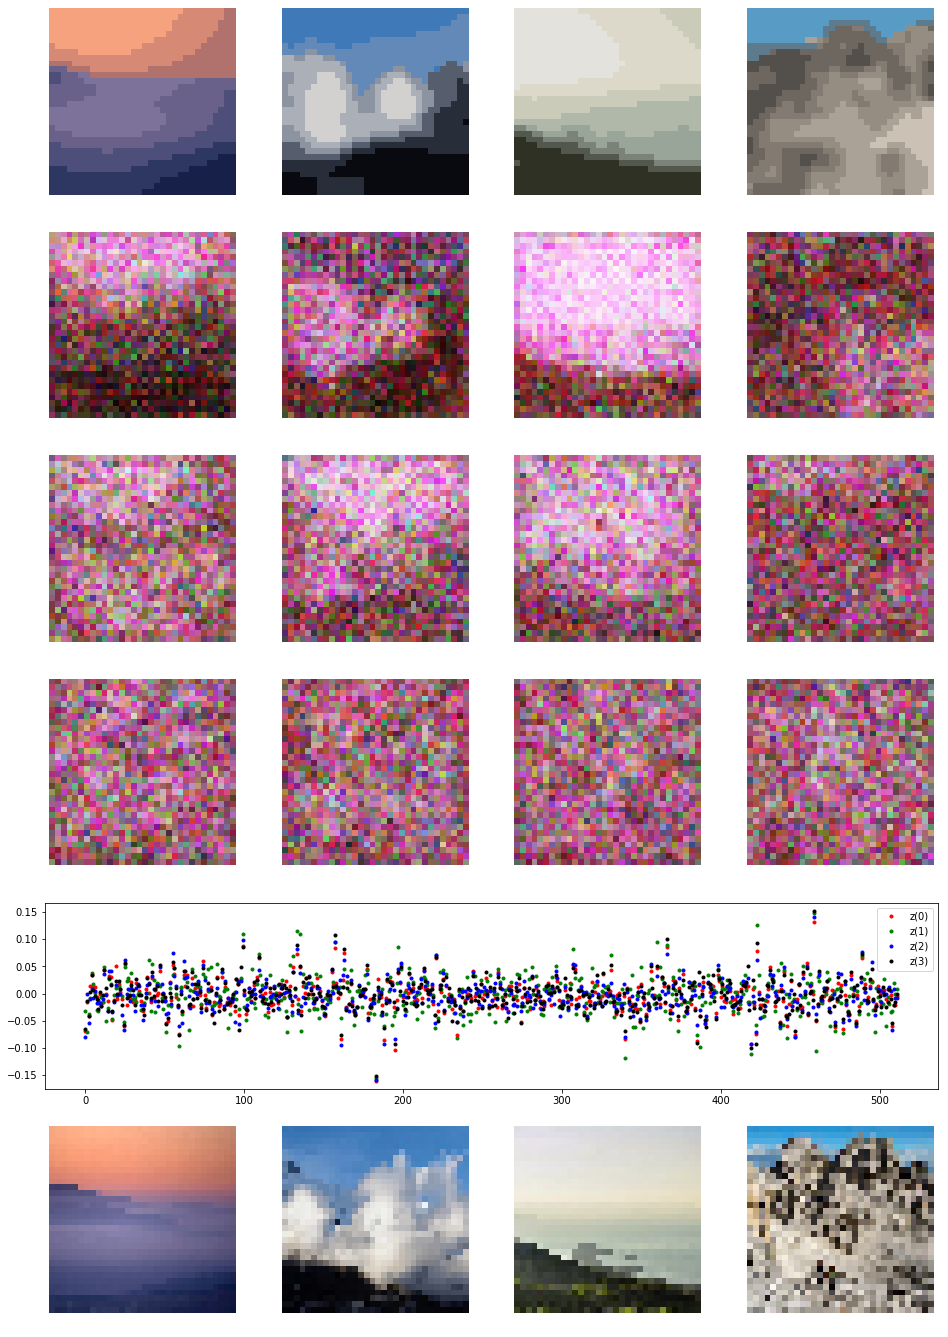

0           15          0.161924        2.89528     0.437488    0.236442    0.934597    0.966819    
     total [###############...................................] 30.00%
this epoch [..................................................]  0.56%
        15 iter, 0 epoch / 50 iterations
  0.004335 iters/sec. Estimated time to finish: 2:14:33.789487.


In [0]:
trainer.run()

In [0]:
if this_resolution_is_fin:
    del gen.de2_3, gen.debn2_3, dis_gen.c3_0, dis_gen.bn3_0
chainer.serializers.save_npz(OUT+'korosu_gen.npz', gen)
chainer.serializers.save_npz(OUT+'korosu_dis_gen.npz', dis_gen)
chainer.serializers.save_npz(OUT+'korosu_opt_gen.npz', opt_gen)
chainer.serializers.save_npz(OUT+'korosu_opt_dis_gen.npz', opt_dis_gen)